In [199]:
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
iris = load_iris()
X, y = iris.data, iris.target

Applying linear PCA on the iris dataset

In [200]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    #cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4)#, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.6,
            #c=cmap(idx),
            edgecolor='black',
            marker=markers[idx],
            label=cl)

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state = 1)
pca = PCA(n_components=2)

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.fit_transform(x_test)

lda = LDA(n_components=2)
x_train_lda = lda.fit_transform(x_train,y_train)
x_test_lda = lda.fit_transform(x_test,y_test)

# Plot of Linear discriminated dataset

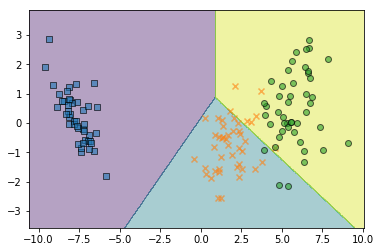

In [202]:
lr = LogisticRegression(solver = "liblinear",multi_class="auto")
lr.fit(x_train_lda,y_train)
plot_decision_regions(x_train_lda,y_train,lr)

# Plot of Principal component analysed dataset 

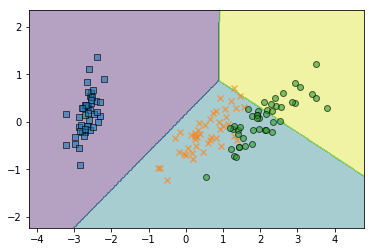

In [203]:
x_train_pda_lda = lda.fit_transform(x_train_pca,y_train)
x_test_lda_2 = lda.fit_transform(x_test_pca,y_test)
plot_decision_regions(x_train_pca,y_train,lr)

# Plot on the dataset that is first PCA'd then LDA'd 

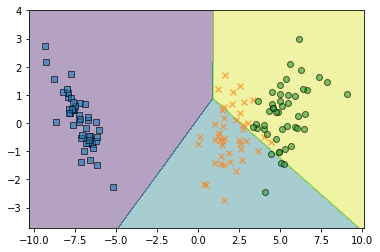

In [204]:
plot_decision_regions(x_train_pda_lda,y_train,lr)

This seperation looks fine, but what if the dataset is not linearly seperable like the one below

In [205]:
from sklearn.datasets import make_moons
X,y = make_moons(n_samples=100,random_state = 1)

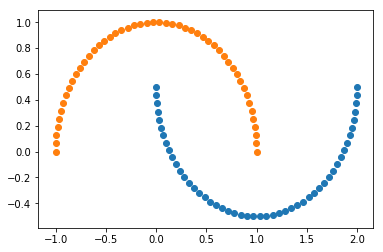

In [206]:
plt.scatter(X[y==1,0],X[y==1,1])
plt.scatter(X[y==0,0],X[y==0,1])
plt.show()

Here we cannnot use linear PCA if we do we will get the following result

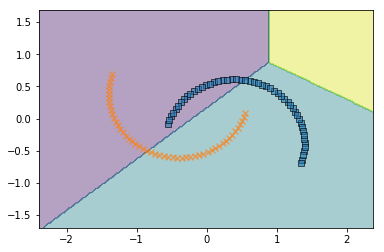

In [207]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pca_2 = PCA(n_components=2)
X_pca = pca_2.fit_transform(X)
lr_2 = LogisticRegression(solver = "liblinear",multi_class="auto")
lr_2.fit(X_pca,y)
plot_decision_regions(X_pca,y,lr)

For this we will need kernel-PCA which is as follows

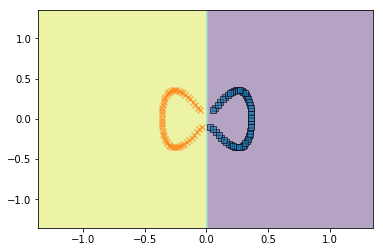

In [208]:
from sklearn.decomposition  import KernelPCA
kpca = KernelPCA(kernel = "rbf",n_components=2,gamma = 15)
X_kpca = kpca.fit_transform(X)
lr_2.fit(X_kpca,y)
plot_decision_regions(X_kpca,y,lr_2)

**Voila! A perfect seperation**

In [210]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc

mean_tpr = 0
mean_fpr = np.linspace(0,1,100)
def compute_roc(X,y,classifier):
    cv = list(StratifiedKFold(n_splits = 3,random_state = 1).split(x_train_pda_lda,y_train))
    lr = LogisticRegression(solver = "liblinear",multi_class="auto")
    i = 1
    mean_tpr = 0
    mean_fpr = np.linspace(0,1,100)
    for (train, test) in cv:
        probabs = lr.fit(X[train],
                     y[train]).predict_proba(X[test])
        fpr, tpr, threshold = roc_curve(y[test],probabs[:,1],pos_label=1)
        mean_tpr += np.interp(mean_fpr,fpr,tpr)
        mean_tpr[0] = 0.0
        plt.plot(fpr,tpr,label = "ROC of fold {} area = {}".format(i,auc(fpr,tpr)))
        i+=1
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr,mean_tpr)
    plt.plot(mean_fpr,mean_tpr,label = "mean ROC area = {}".format(auc(mean_fpr,mean_tpr)),c= "k",ls = "-.")
    plt.legend(loc = "best")
    plt.show()
    

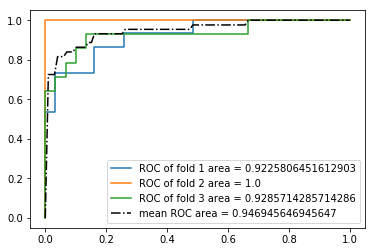

In [211]:
compute_roc(x_train_lda,y_train, lr)

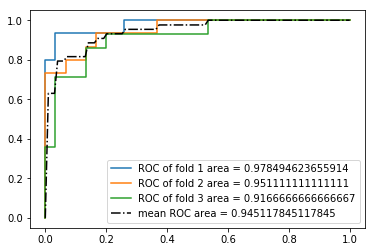

In [212]:
compute_roc(x_train_pda_lda,y_train,lr)

Above the ROC curves of *x_train_lda* and *x_train_pca_lda* which shows that doing a LDA on an already PCA'd dataset is not a bad idea as we can see the mean ROC is roughly the same